In [1]:
import haiku as hk
import jax
import jax.random as jrnd
import jax.numpy as jnp

import numpy as np

In [2]:
from jax.lax import map as jmap

In [3]:
from jax.experimental import sparse

In [4]:
from modules import *
from utils import *
from spiking import *

In [5]:
import matplotlib.pyplot as plt

In [6]:
key = random.PRNGKey(42)

In [7]:
key, sk1, sk2 = random.split(key, 3)

In [8]:
shp = (1, 100, 1024)
phases = random.uniform(sk1, shp, minval=-1.0, maxval=1.0) * (random.uniform(sk2, shp, minval=0.0, maxval = 1.0) > 0.25)

In [9]:
phases.shape

(1, 100, 1024)

In [10]:
jnp.mean(phases == 0.0)

DeviceArray(0.25134766, dtype=float32)

In [11]:
sl0 = phases[0,...]

In [12]:
sl0.shape

(100, 1024)

In [13]:
aa = jnp.stack(jnp.nonzero(sl0), axis=0)

In [14]:
aa.shape

(2, 76662)

In [15]:
ab = list(map(lambda x: jnp.tile(x, reps=2), jnp.nonzero(sl0)))

In [16]:
ad = jnp.argwhere(sl0)

In [17]:
sl0.shape

(100, 1024)

In [18]:
100 * 1024

102400

In [19]:
ad.shape

(76662, 2)

In [20]:
sl1 = sl0[jnp.nonzero(sl0)]

In [21]:
sl1.shape

(76662,)

In [22]:
sl1

DeviceArray([ 0.03607059, -0.7077575 ,  0.68582773, ...,  0.89667535,
              0.10641217,  0.9088719 ], dtype=float32)

In [52]:
jnp.nonzero(sl0)

(DeviceArray([ 0,  0,  0, ..., 99, 99, 99], dtype=int32),
 DeviceArray([   2,    3,    4, ..., 1017, 1020, 1023], dtype=int32))

In [64]:
def phase_to_train(x, period: float = 1.0, repeats: int = 3):
    """
    Given a series of input phases defined as a real tensor, convert these values to a 
    temporal spike train. 
    """ 
    t_phase0 = period/2.0
    shape = x.shape
    
    x = x.ravel()

    #list and repeat the index 
    inds = jnp.nonzero(x)

    #list the time offset for each index and repeat it for repeats cycles
    times = x[inds]
    order = jnp.argsort(times)
    
    #sort by time
    times = times[order]
    inds = [jnp.take(inds[0], order)]
    
    n_t = times.shape[0]
    dtype = x.dtype
    
    times = times * t_phase0 + t_phase0

    #tile across time
    inds = [jnp.tile(inds[0], (repeats))]
    times = jnp.tile(times, (repeats))
        
    #create a list of time offsets to move spikes forward by T for repetitions
    offsets = jnp.arange(0, repeats, dtype=dtype) * period
    offsets = jnp.repeat(offsets, n_t)

    times += offsets
    
    return (inds, times, shape)

In [65]:
ac = phase_to_train(phases)

In [66]:
ac[0]

[DeviceArray([80972, 85847, 98856, ...,  2050, 50795, 29788], dtype=int32)]

In [69]:
ac[0][0].shape

(229986,)

In [67]:
ac[1].shape

(229986,)

In [70]:
ac[2]

(1, 100, 1024)

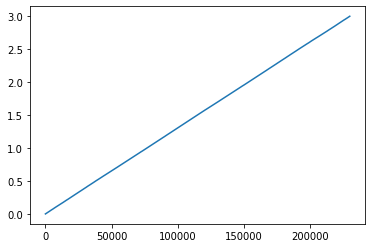

In [68]:
plt.plot(ac[1])

In [75]:
from jax.lax import scatter

In [112]:
def current(x, t, box = 0.03):
    inds, times, full_shape = x
    
    currents = jnp.zeros(full_shape)
    
    #get the times in the current window
    cond = lambda x: (x > t - box) * (x < t + box)
    active = jnp.nonzero(cond(times))
    #swap the time indices for what flattened neuron they refer to
    active = inds[0][active]
    active = jnp.unravel_index(active, full_shape)

    currents = currents.at[active].add(1.0)
    
    return currents
    
    

In [113]:
ag = current(ac, 0.5)

In [114]:
ag

DeviceArray([[[0., 0., 1., ..., 0., 0., 0.],
              [0., 0., 0., ..., 0., 0., 0.],
              [0., 0., 0., ..., 0., 0., 0.],
              ...,
              [0., 0., 0., ..., 0., 0., 0.],
              [0., 0., 0., ..., 0., 0., 0.],
              [0., 0., 0., ..., 0., 0., 0.]]], dtype=float32)

In [115]:
jnp.sum(ag)

DeviceArray(4592., dtype=float32)

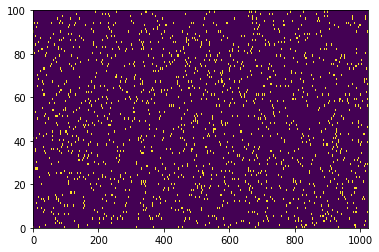

In [116]:
plt.pcolor(ag[0,...])